In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

import datetime
import math
import calendar
import sys
sys.path.append('../')
from scripts.missing_info import MissingValue
from scripts.ploting import Plots
from scripts.Clean_data import  DataCleaner
miss_val = MissingValue()
cleaner=DataCleaner()

In [4]:
train = pd.read_csv('../data/train.csv',low_memory=False)
test = pd.read_csv('../data/test.csv',low_memory=False)
store = pd.read_csv('../data/store.csv',low_memory=False)

train.shape, test.shape, store.shape

((1017209, 9), (41088, 8), (1115, 10))

<b>Merge the Data<b>

In [11]:
data = train.merge(store, on = ['Store'], how = 'inner')
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,is_train,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [12]:
data.shape

(1017209, 19)

In [13]:
data.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
is_train                       int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [14]:
print('Distinct number of Stores:', len(data['Store'].unique()))
print('Distinct number of Stores:', len(data['Date'].unique()))
print('Average daily sales of all Stores:', round(data['Sales'].mean(), 2))

Distinct number of Stores: 1115
Distinct number of Stores: 942
Average daily sales of all Stores: 5773.82


Create new columns related to Dates

In [15]:
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format = True)

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter
data['Week'] = data['Date'].dt.week
data['Day'] = data['Date'].dt.day

data['Season'] = np.where(data['Month'].isin([3,4,5]), "Spring",
                 np.where(data['Month'].isin([6,7,8]), "Summer",
                 np.where(data['Month'].isin([9,10,11]), "Fall",
                 np.where(data['Month'].isin([12,1,2]), "Winter", "None"))))

In [25]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
is_train,1017209.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
CompetitionDistance,1017209.0,5430.085652,7705.297659,20.0,710.0,2330.0,6880.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.222866,3.211832,1.0,4.0,8.0,10.0,12.0


In [16]:
data.iloc[:,-6:].head()

,Year,Month,Quarter,Week,Day,Season
0,2015,7,3,31,31,Summer
1,2015,7,3,31,30,Summer
2,2015,7,3,31,29,Summer
3,2015,7,3,31,28,Summer
4,2015,7,3,31,27,Summer


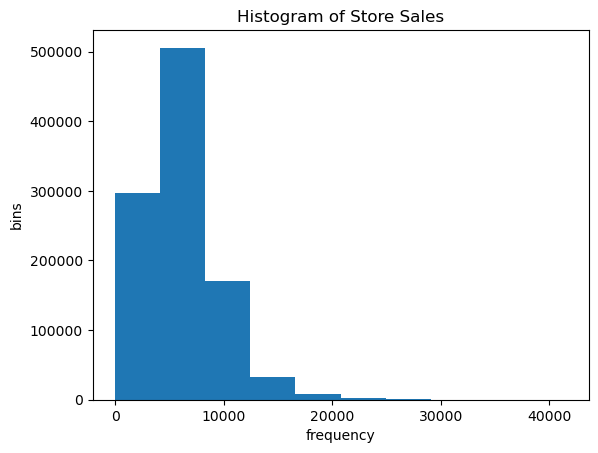

In [17]:
plt.hist(data['Sales'])
plt.title('Histogram of Store Sales')
plt.ylabel('bins')
plt.xlabel('frequency')
plt.show()

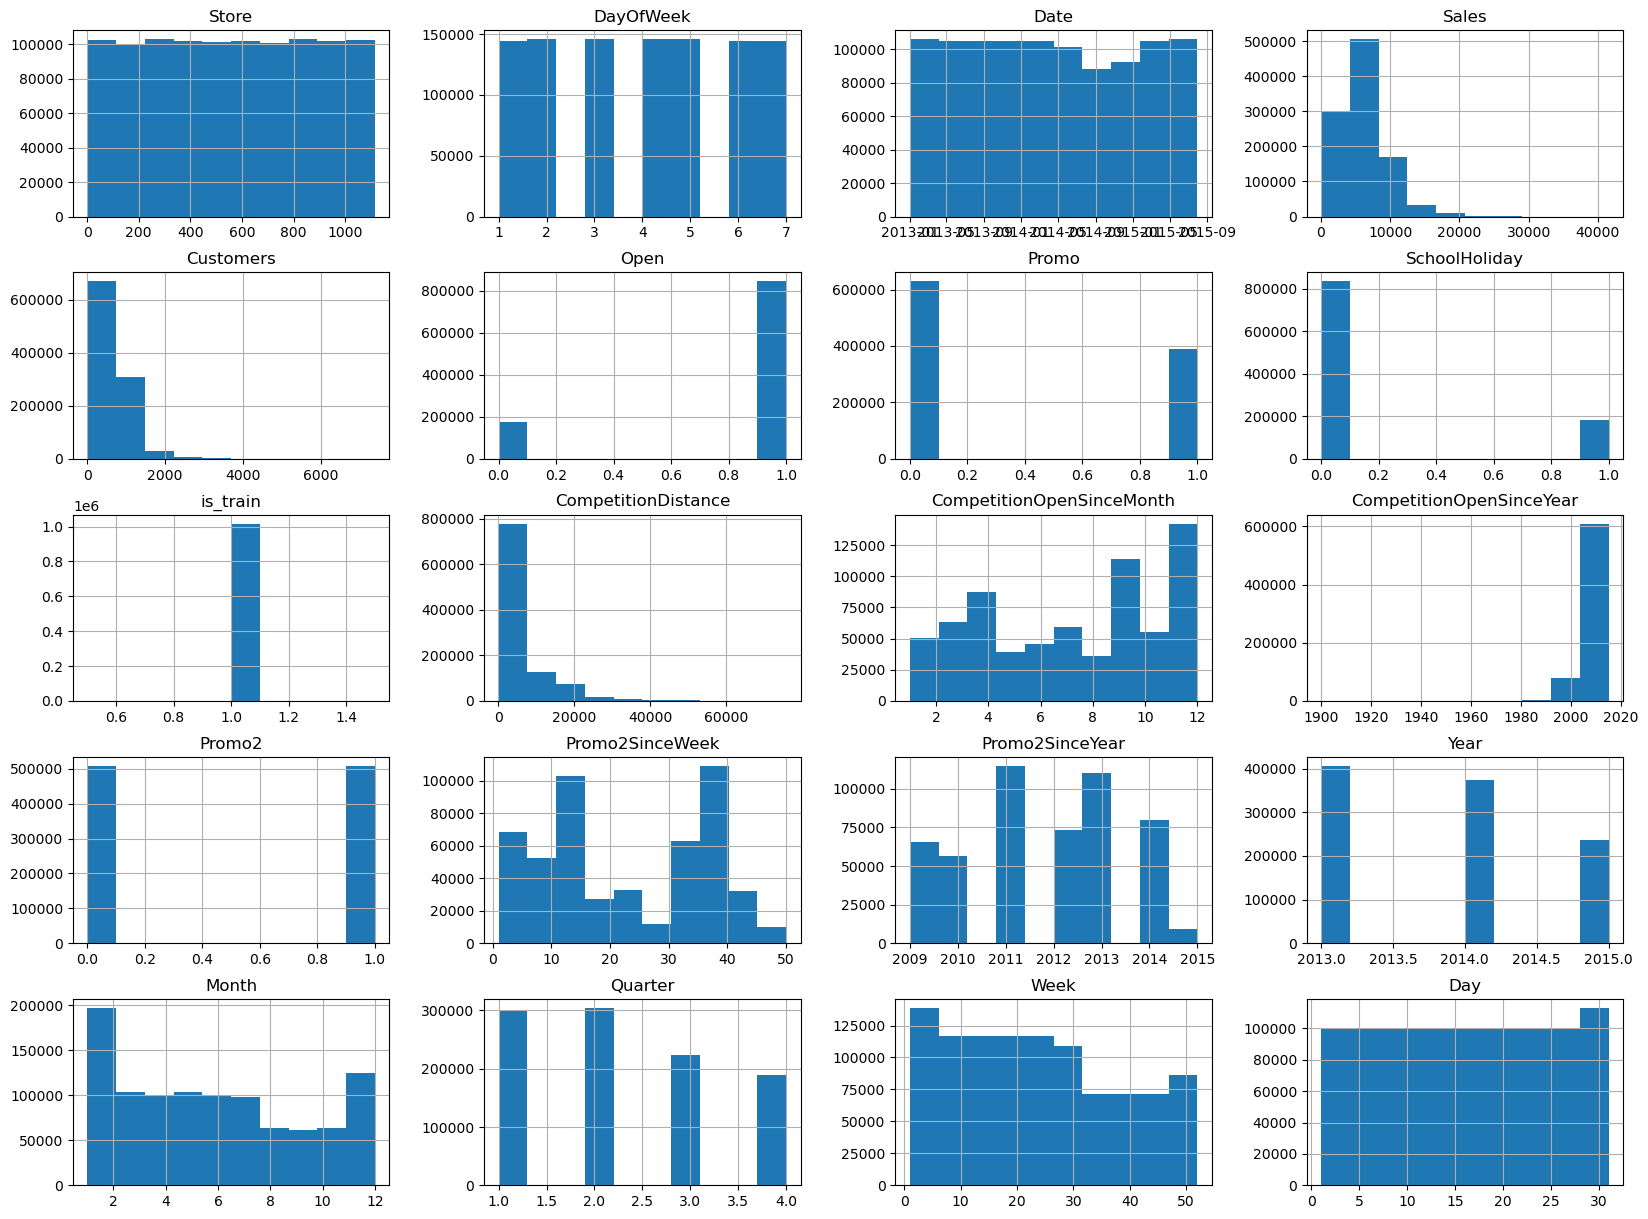

In [19]:
data.hist(figsize = (20,15))
plt.show()

Handle the Missing Values

In [20]:
miss_val.missing_values_table(data)

,Missing Values,% of Total Values,Dtype
Promo2SinceWeek,508031,49.9,float64
Promo2SinceYear,508031,49.9,float64
PromoInterval,508031,49.9,object
CompetitionOpenSinceMonth,323348,31.8,float64
CompetitionOpenSinceYear,323348,31.8,float64
CompetitionDistance,2642,0.3,float64


In [21]:
data['CompetitionDistance'] = data['CompetitionDistance'].fillna(
                                    data['CompetitionDistance'].mean())

Encode the Data

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

target = ['Sales']
numeric_col = ['Customers', 'Open', 'Promo', 'Promo2', 'StateHoliday', 'SchoolHoliday', 'CompetitionDistance']
categorical_col = ['DayOfWeek', 'Quarter', 'Month', 'Year', 'StoreType', 'Assortment', 'Season']

def create_encode(df, col):
    le = LabelEncoder()
    a = le.fit_transform(data[col]).reshape(-1,1)
    ohe = OneHotEncoder(sparse=False)
    col_names = [col+ "_" + str(i) for i in le.classes_]
    return (pd.DataFrame(ohe.fit_transform(a), columns = col_names))

In [23]:
temp = data[numeric_col]

for col in categorical_col:
    temp_df = create_encode(data, col)
    temp = pd.concat([temp, temp_df], axis=1)

In [24]:
print('Shape of Data: ', temp.shape)
print('Distinct Datatypes: ', temp.dtypes.unique())

Shape of Data:  (1017209, 44)
Distinct Datatypes:  [dtype('int64') dtype('O') dtype('float64')]


Split the Data

In [32]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,is_train
0,1,5,2015-07-31,5263,555,1,1,0,1,1
1,2,5,2015-07-31,6064,625,1,1,0,1,1
2,3,5,2015-07-31,8314,821,1,1,0,1,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,1
4,5,5,2015-07-31,4822,559,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,1


In [30]:
train.shape

(1017209, 10)

In [31]:
test.shape

(41088, 9)

Normalize the data

<b>`Feature Engineering and Preprocessing`<b>

In [6]:
features_x = ['Store', 'Date', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

In [7]:
train['is_train'] = 1
test['is_train'] = 0
df = pd.concat([train, test])

In [8]:
df.Date = pd.to_datetime(df.Date) #Converting date to required format

In [9]:
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))] #Removing rows with Sales 0

In [ ]:
df.StateHoliday = df.StateHoliday.map({0:'0', 'a':'a', 'b':'b', 'c':'c', '0':'0'}) #mixed data types
df.StateHoliday = LabelEncoder().fit_transform(df.StateHoliday) #Encoding for XG Boost